In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from pmdarima import auto_arima
from scipy.stats import normaltest
from statsmodels.tsa.stattools import adfuller
from statsmodels.tools import eval_measures

In [2]:
def ADF_Stationarity_Test(timeseries, significance=.01):
    SignificanceLevel = significance

    #Dickey-Fuller test:
    adfTest = adfuller(timeseries, autolag='AIC')

    pValue = adfTest[1]

    if (pValue<SignificanceLevel):
        isStationary = True
    else:
        isStationary = False
        
    dfResults = pd.Series(adfTest[0:4], index=['ADF Test Statistic','P-Value','# Lags Used','# Observations Used'])

    #Add Critical Values
    for key,value in adfTest[4].items():
        dfResults['Critical Value (%s)'%key] = value

    print('Augmented Dickey-Fuller Test Results:\n')
    print(dfResults)
    print('\nTime series is stationary? {}'.format(isStationary))

In [3]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# 2 Forecasting

In [4]:
pla = pd.read_csv('pla_data.csv', sep=';', decimal=',')
pla.Date = pd.to_datetime(pla.Date, dayfirst=True)
pla = pla.set_index('Date')
pla.index.freq = 'MS'

## 2.1 Introduction

Due to the fact that the amount of given data is really small, makes no sense to try to use advanced methods to forecast future time series. That would be rather useless and at worst it could overfit the training data resulting in a really poor generalization. Thus, it is expected that a somewhat simple model is going to perform equal or better than advanced forecasting methods. With this amount of data, no complex pattern could be discovered and simply plotting the costs for each month one can find the qualitative behaviour that any algorithm (at most) could detect.

In the next subsection we will see that the qualitative behaviour of the different columns is the same, thus the same methods can be applied to all of them. **Consequently, I will only do the analysis for the column *Costs***, as the exact same logic applies to the rest of the columns.

We will explore several methods: 
1. SARIMA  
2. Holt-Winters
3. Weighted average


Given the amount of data provied, the testing of the forecasting hypotesis can not be rigorously done. Rather, we can make a small test that might give us a hint that we are on the right track. In order to estimate the quality of the forecasting I am going to use *Mean Absolute Percentage Error*.

In [5]:
mape = pd.DataFrame(columns = ['Holt-Winters', 'sarima', 'weighted average'], index = ['MAPE'])

## 2.2 Explore the data

Let's first plot all the relevant columns from the dataframe:

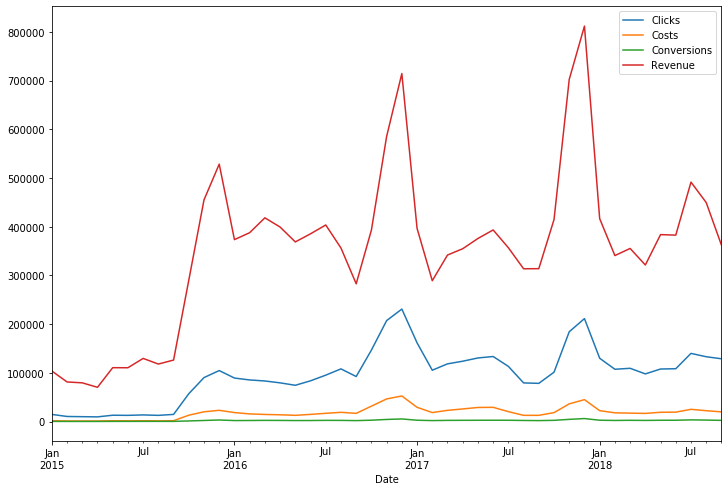

In [6]:
pla[['Clicks', 'Costs', 'Conversions', 'Revenue']].plot(figsize=(12,8))

Due to the differences in scale, the Conversions and Costs are hard to compare to Clicks and Revenue. But we can already see that there is certain similarity. Let's plot them in different plots but in the same figure:

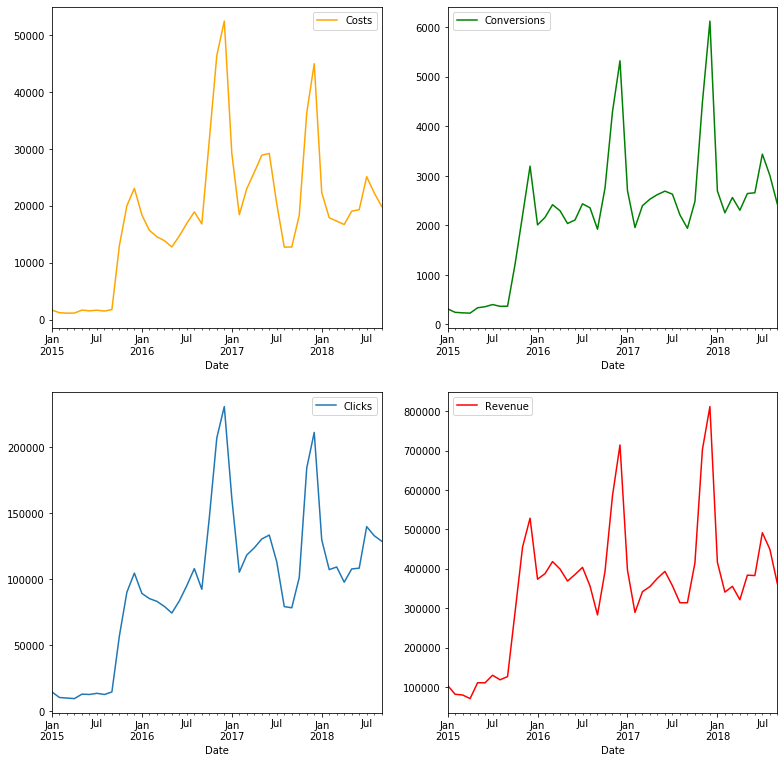

In [7]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(13,13))
pla.Costs.plot(ax=axes[0,0],legend=True, color='orange')
pla.Clicks.plot(ax=axes[1,0], legend=True)
pla.Conversions.plot(ax=axes[0,1], legend=True, color='green')
pla.Revenue.plot(ax=axes[1,1], legend=True, color='red')

We can see big similarities. In order to quantify it in numbers, we can compute the correlation between columns: 

In [8]:
pla[['Clicks', 'Costs', 'Conversions', 'Revenue']].corr()

,Clicks,Costs,Conversions,Revenue
Clicks,1.000000,0.980729,0.957587,0.914555
Costs,0.980729,1.000000,0.944029,0.907755
Conversions,0.957587,0.944029,1.000000,0.976912
Revenue,0.914555,0.907755,0.976912,1.000000


Such a high correlation means that all the columns have an almost linear relationship with each other, i.e. Clicks $\propto$ Costs $\propto$ Conversions $\propto$ Revenue. 

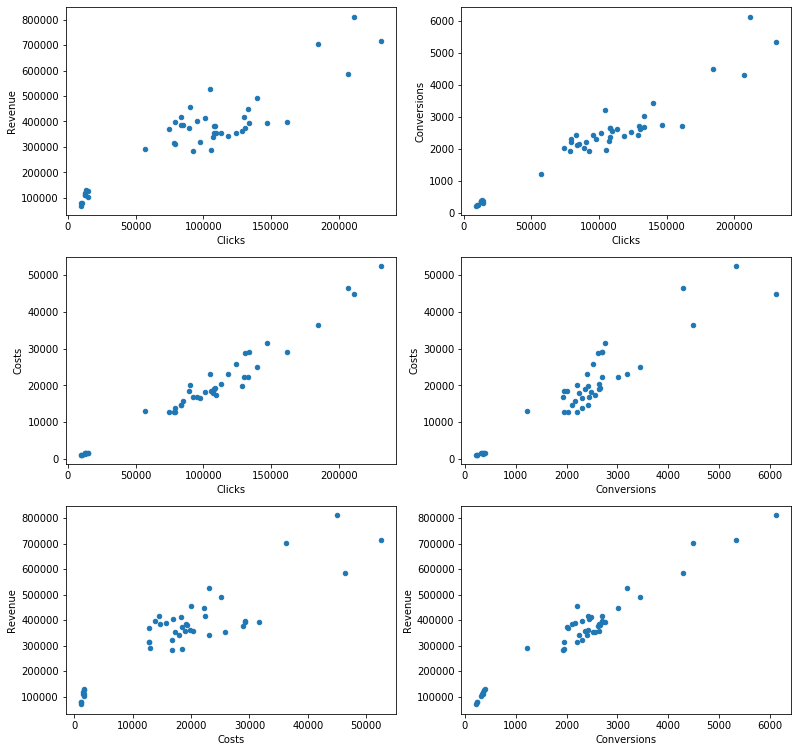

In [9]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(13,13))
pla.plot.scatter(ax=axes[0,0], x='Clicks', y='Revenue',legend=True)
pla.plot.scatter(ax=axes[1,0], x='Clicks', y='Costs', legend=True)
pla.plot.scatter(ax=axes[0,1], x='Clicks', y='Conversions', legend=True)
pla.plot.scatter(ax=axes[1,1], x='Conversions', y='Costs', legend=True)
pla.plot.scatter(ax=axes[2,0], x='Costs', y='Revenue', legend=True)
pla.plot.scatter(ax=axes[2,1], x='Conversions', y='Revenue', legend=True)

## 2.3 Forecast Methods

Let's split the data between training and test sets:

In [10]:
train_size = 32
train, test = pla.Costs[:train_size], pla.Costs[train_size-1:]

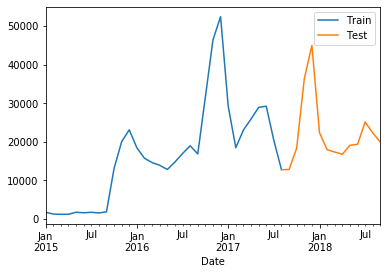

In [11]:
ax = train.plot(legend=True)
test.plot(legend=True)
ax.legend(["Train", "Test"])

Given the small amount of data it's hard to choose a good training size: If we choose it too big, the tests will be not significant at all, if we choose it too small the models will be undertrained. Thus after some tests I suggest to use 32 as the correct size.

### 2.3.1 Holt-Winters

When we look at the second plot of this document we can see there is seasonality in the data. Let's try to decompose the Costs:

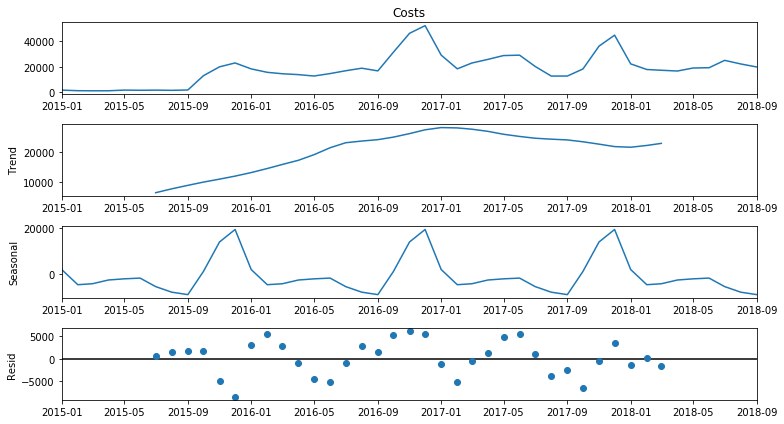

In [12]:
decomposition = sm.tsa.seasonal_decompose(pla['Costs'], period=12)
fig = decomposition.plot()
fig.set_size_inches(11, 6)
plt.tight_layout()

Even though the Residue can not be considered as noise, it is clearly an order of magnitue smaller than the Seasonal and Trend parts (the noise makes up 10% of the total). This means we clearly can decompose the Time Series into a Seasonal and Trend parts using for example Exponential Smoothing.

In [13]:
HoltWinters = ExponentialSmoothing(train, seasonal='add', seasonal_periods=12).fit()
pred_HW = HoltWinters.predict(start=0, end=len(train)+len(test)+14)

/Users/arnaujc/miniconda3/envs/check24/lib/python3.6/site-packages/statsmodels/tsa/holtwinters.py:744: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  ConvergenceWarning)


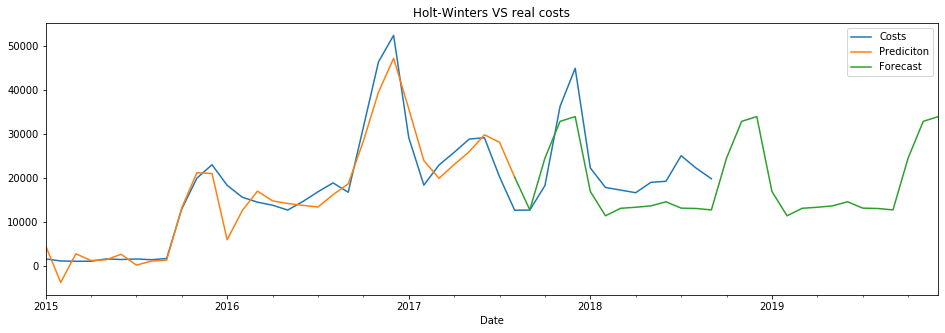

In [14]:
ax = pla.Costs.plot(figsize = (16,5), legend=True, title='Holt-Winters VS real costs')
pred_HW[:len(train)].plot(legend=True)
pred_HW[len(train)-1:len(train)+len(test)+14].plot(legend=True)
ax.legend(["Costs", "Prediciton","Forecast"])

We are dividing the output of the model between *Prediction* and *Forecast*. Prediction is the part of the output that corresponds to the dates of the training data, Forecast instead is output of the model for dates which it has not been trained.

**Mean absolute percentage error for Holt-Winters:**

In [15]:
mape['Holt-Winters'] = mean_absolute_percentage_error(y_true=test, y_pred=pred_HW[len(train):len(test)+len(train)])
mape['Holt-Winters']

MAPE    26.769667
Name: Holt-Winters, dtype: float64

### 2.3.2 SARIMA

(S)ARIMA models require some paramaters to be given by the user, these are called the order of the model and are denoted as $(p,d,q)$ for ARIMA and as $(p,d,q)(P,D,Q)_m$ for SARIMA. In order to estimate these one can use the Auto Correlation Function (ACF) and the Partial Auto Correlation Function (PACF).

/Users/arnaujc/miniconda3/envs/check24/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


Text(0.5, 0.98, 'ACF and PACF for the Costs')

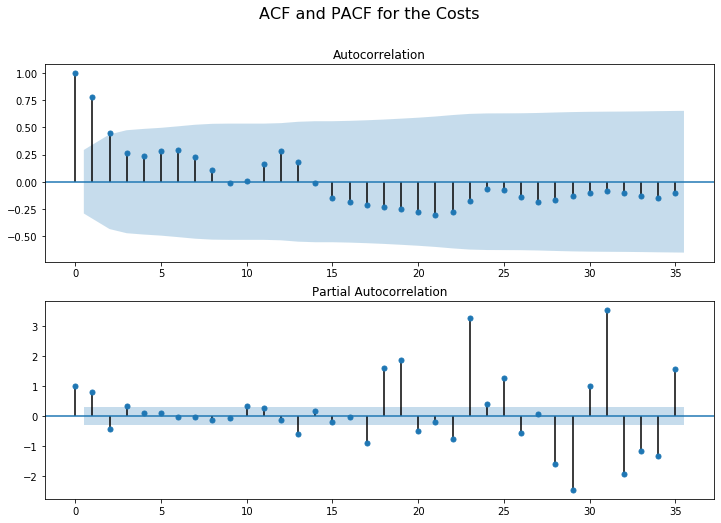

In [16]:
fig = plt.figure(figsize=(12,8), )
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(pla['Costs'], lags=35, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(pla['Costs'], lags=35, ax=ax2)
fig.suptitle('ACF and PACF for the Costs', fontsize=16)

There is a clear correlation, at least between the value of the series ($y_t$) and its lagged version ($y_{t-1}$). We can take a stationarity test to check if the Series is stationary.

In [17]:
ADF_Stationarity_Test(pla.Costs)

Augmented Dickey-Fuller Test Results:

ADF Test Statistic      -3.406294
P-Value                  0.010746
# Lags Used              1.000000
# Observations Used     43.000000
Critical Value (1%)     -3.592504
Critical Value (5%)     -2.931550
Critical Value (10%)    -2.604066
dtype: float64

Time series is stationary? False


As expected we can conclude that the Time Series is not stationary with a 99% confidence level. It is worth remarking though, that if we would have required a 95% confidence level the test would have suggested that the time series was, in fact, stationary.

Now we will consider the first difference of the Time Series.

In [18]:
first_difference = (pla.Costs-pla.Costs.shift(periods=1)).iloc[1:]
ADF_Stationarity_Test(first_difference)

Augmented Dickey-Fuller Test Results:

ADF Test Statistic     -6.231942e+00
P-Value                 4.929123e-08
# Lags Used             1.000000e+00
# Observations Used     4.200000e+01
Critical Value (1%)    -3.596636e+00
Critical Value (5%)    -2.933297e+00
Critical Value (10%)   -2.604991e+00
dtype: float64

Time series is stationary? True


Once we obtain a Stationary Time Series out of our original Time Series, we can plot again the ACF and PACF in order to obtain the order of the SARIMA model. There are certain heuristic rules to estimate the order out of the ACF and PACF: see [Identifying the numbers of AR or MA terms in an ARIMA model](https://people.duke.edu/~rnau/411arim3.htm), [seasonal ARIMA models](https://otexts.com/fpp2/seasonal-arima.html).


/Users/arnaujc/miniconda3/envs/check24/lib/python3.6/site-packages/statsmodels/regression/linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


Text(0.5, 0.98, 'ACF and PACF for the 1-Lag Costs')

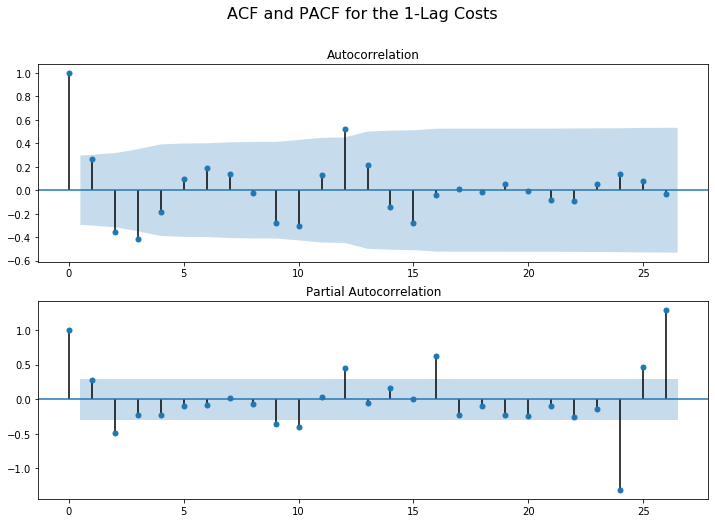

In [19]:
fig = plt.figure(figsize=(12,8), )
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(first_difference, lags=26, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(first_difference, lags=26, ax=ax2)
fig.suptitle('ACF and PACF for the 1-Lag Costs', fontsize=16)

Our differenced series, despite being stationary, does not seem to follow any of the heuristic rules to estimate the SARIMA order. Therefore we will use instead auto_arima, which will find the best values for our data:

In [20]:
auto_arima(pla.Costs, seasonal=True, m=12,max_p=7, max_d=5,max_q=7, max_P=4, max_D=4,max_Q=4).summary()

/Users/arnaujc/miniconda3/envs/check24/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:868: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)
/Users/arnaujc/miniconda3/envs/check24/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:868: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)
/Users/arnaujc/miniconda3/envs/check24/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:868: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  ' zeros.' % warning_description)
/Users/arnaujc/miniconda3/envs/check24/lib/python3.6/site-packages/statsmodels/tsa/statespace/sarimax.py:868: UserWarning: Too few obser

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                   45
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -324.854
Date:                            Tue, 25 Feb 2020   AIC                            651.709
Time:                                    17:15:41   BIC                            653.174
Sample:                                         0   HQIC                           652.195
                                             - 45                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      3.735e+07   6.94e+06      5.380      0.000    2.37e+07     5.1e+07
===================================================================================
Ljung-Box (Q):                       28.98   Jarque-Bera (JB):                 4.20
Prob(Q):                              0.57   Prob(JB):                         0.12
Heteroskedasticity (H):               3.06   Skew:                            -0.60
Prob(H) (two-sided):                  0.08   Kurtosis:                         4.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [21]:
sarima_model = sm.tsa.statespace.SARIMAX(train, order = (0,1,0), seasonal_order = (0,1,0,12))
sarima_result = sarima_model.fit()
sarima_result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Costs   No. Observations:                   32
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 12)   Log Likelihood                -193.765
Date:                            Tue, 25 Feb 2020   AIC                            389.530
Time:                                    17:15:42   BIC                            390.474
Sample:                                01-01-2015   HQIC                           389.689
                                     - 08-01-2017                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2       3.97e+07   9.16e+06      4.332      0.000    2.17e+07    5.77e+07
===================================================================================
Ljung-Box (Q):                       15.14   Jarque-Bera (JB):                 4.39
Prob(Q):                              0.65   Prob(JB):                         0.11
Heteroskedasticity (H):              15.62   Skew:                            -1.11
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.77
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

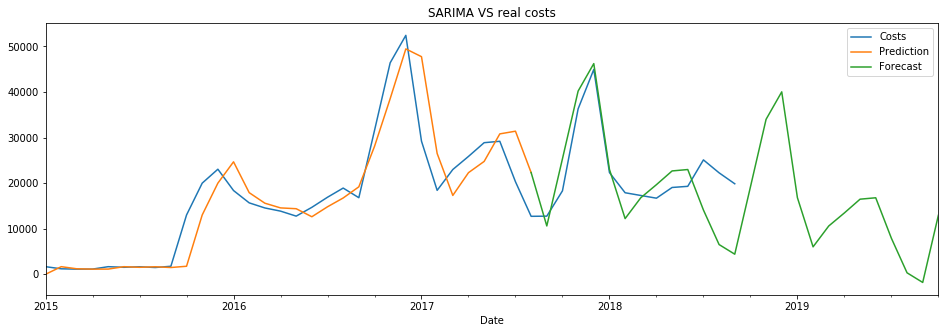

In [22]:
pred_sarima = sarima_result.predict(start=0, end=len(train)+len(test)+12)
ax = pla.Costs.plot(figsize = (16,5), legend=True, title='SARIMA VS real costs')
pred_sarima[:len(train)].plot(legend=True)
pred_sarima[len(train)-1:len(train)+len(test)+12].plot(legend=True)
ax.legend(["Costs", 'Prediction' , "Forecast"])

**Mean absolute percentage error for SARIMA:**

In [23]:
mape['sarima'] = mean_absolute_percentage_error(y_true=test, y_pred=pred_sarima[len(train):len(test)+len(train)])
mape['sarima']

MAPE    27.29625
Name: sarima, dtype: float64

### 2.3.3 Weighted average

This is clearly the simplest of the models. What we are going to do is to take a weighted average of the same month of previous years to forecast the same month for a coming year. 

\begin{equation*}
v_{m,y} = \frac{3}{10} \times v_{m, \,2015} + \frac{7}{10}\times v_{m, \,2016} 
\end{equation*}

where $m \in \{1,2, \ldots , 12\}$ stands for month, $y \in \{2017,2018,2019\}$ stands for year and $v_{m,y}$ is the value of the variable in the respective month and year. In this way we will have a forecast that has the same qualitative behaviour as the previous data even though we know that quantitatively might not be perfect.

In [24]:
piv = pd.pivot_table(pla, index=['Month'], columns=['Year'], values=['Costs'])

In [25]:
piv.loc[:,('forecast', 2018)] = 3/10*piv.loc[:,('Costs', 2015)] + 7/10*piv.loc[:,('Costs', 2016)]
piv.loc[:,('forecast', 2019)] = 3/10*piv.loc[:,('Costs', 2015)] + 7/10*piv.loc[:,('Costs', 2016)]

In [26]:
pred_wa = pd.Series(np.array(piv.loc[:,('forecast',2019)].to_list()*5))
pred_wa.index = pd.date_range(start='2015-01-01', end='2019-12-01', freq='MS')

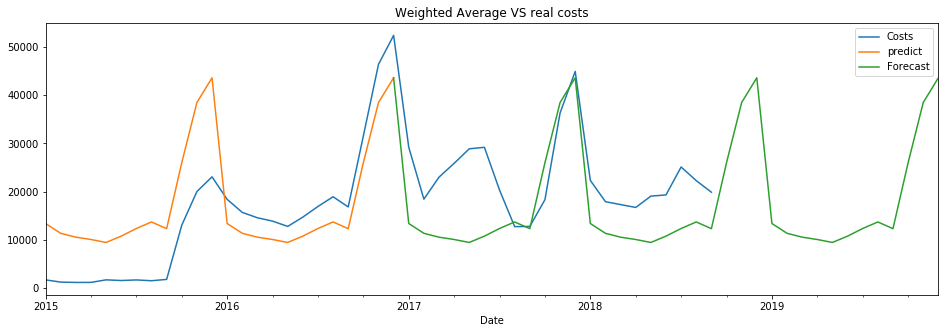

In [31]:
ax = pla.Costs.plot(figsize = (16,5), legend=True, title='Weighted Average VS real costs')
pred_len = 24
pred_wa[:pred_len].plot(legend=True)
pred_wa[pred_len-1:].plot(legend=True)
ax.legend(["Costs",'predict', "Forecast"])

**Mean absolute percentage error for Weighted average:**

In [28]:
mape['weighted average'] = mean_absolute_percentage_error(y_true=test, y_pred=pred_wa[len(train):len(train) + len(test)])
mape['weighted average']

MAPE    33.283417
Name: weighted average, dtype: float64

## 2.4 Summary

We have tested three different methods to forecast future values. All models perform similarly, with the best performance for the Holt-Winters model. With the small amount of data given, the results can not be taken as very statistically signficant. Thus, in order to improve performance there is *at least* one requirement: more data. Then depending on the amount of data more sophisticated methods can be tested, for example neural networks. 

In [29]:
mape

,Holt-Winters,sarima,weighted average
MAPE,26.769667,27.29625,33.283417


The fact that such a simple model like Weighted Average gives similar results to more complex models like SARIMA means at least one of two possible things:
- There is not enough data: 
- The pattern is either too simple or too complex: in the case it is too simple, both SARIMA and Weighted Average can capture it and thus they give similar results. In the case it is too complex none of them can capture the pattern and both forecasts are not related to the input, and fail equally badly.
